# Quantum Tracer
Using the quantum technology this program intends to trace the probability of people being infected when some cases are detected in a population. The information of interaction is obtained from the signal information of people that was in contact.
Using the correct tecnology from IBMQ, we are able to simulate up to 32 people. However, in a near future we belive this will be increase exponentially based on the effort that different companies are putting in quantum technology.
Our algorithm is divided in 4 steps:

1) Data adquisition

2) Data processing

3) Data presentation in graphs

4) Interaction simulation qiskit

## 1) Data adquisition

Using a data base of people interaction we can create a model to determine if the people were in contact and how long the contact was. Here, we present the code from load the data and how to preprocess it to have the interaction time. 

In [2]:
import getpass, math, matplotlib, os, pymysql, time
import networkx as nx, numpy as np, pandas as pd, sqlalchemy as sql

In [3]:
password = getpass.getpass()

connection = pymysql.connect(host = 'qcontact.c6byqjxwxxbt.us-east-1.rds.amazonaws.com',
                             port = 3306,
                             user = 'admin',
                             password = password,
                             db = '',
                             charset = 'utf8mb4',
                             cursorclass = pymysql.cursors.DictCursor)

········


In [15]:
cursor = connection.cursor()
cursor.execute('USE anon_btlog')
dates = pd.read_sql("SELECT Date, COUNT(*) FROM anon_logdata GROUP BY Date", connection)
dates

,Date,COUNT(*)
0,2005-10-31,335
1,2005-11-01,834
2,2005-11-02,508


The data below represent the time that people were in a specific place. From here, we can extract if that people were in contact and how long the interaction was. 

In [46]:
firstLast1031 = pd.read_sql("SELECT Address, MIN(Time), MAX(Time) FROM anon_logdata "\
                      "WHERE Date='2005-10-31' GROUP BY Address", connection)
firstLast1101 = pd.read_sql("SELECT Address, MIN(Time), MAX(Time) FROM anon_logdata "\
                      "WHERE Date='2005-11-01' GROUP BY Address", connection)
firstLast1102 = pd.read_sql("SELECT Address, MIN(Time), MAX(Time) FROM anon_logdata "\
                      "WHERE Date='2005-11-02' GROUP BY Address", connection)
firstLast1102.sort_values('MIN(Time)')

,Address,MIN(Time),MAX(Time)
2,08cee2e84bbd42dc82931404627ba88c,00:53:21,00:54:17
3,2a1a384c01214fdf764fb415381157c7,00:53:59,00:54:17
1,0200e01ce58988023644b1a4f11168e3,08:30:46,11:07:21
9,96dbec31c17d68e38ec48406ffa99a8d,11:25:59,14:17:53
8,776d3625e915cd55b1a3b249b958cebe,11:26:04,14:17:54
4,2d1f2bd68c3d4a16a972198da151bd9a,11:49:27,13:01:26
5,4a3dacbfc570d4931d99ae862a73791d,13:54:01,14:03:22
6,68ece46dd8262e0b422773460844ce73,13:54:08,13:59:21
7,735c38802d17fd219577cea31faa082f,13:54:08,13:56:21
0,01f052ae6021e25f2f00d61e88287ae3,13:54:20,13:56:21


# Toy Example

Now, we are going to select the information of the day 11/02/2005. To present how it is going to be simulated in the quantum computer.

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


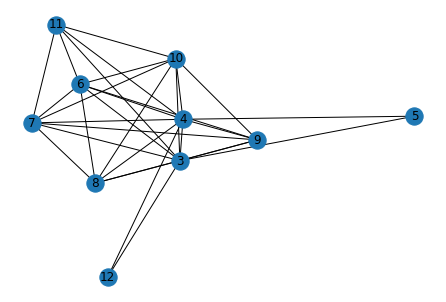

In [72]:
sorted_values = firstLast1102.sort_values('MIN(Time)')
people = sorted_values.shape[0]
G = nx.Graph()
G.add_nodes_from(range(people))


coming_time = sorted_values['MIN(Time)']
leaving_time = sorted_values['MAX(Time)']
interaction = []; time_together = []; contact_start = []
for first_person in range(people - 1):
    for second_person in range(first_person + 1, people):
        if leaving_time.iloc[first_person] < coming_time.iloc[second_person]:
            break
        else:
            G.add_edges_from([(first_person,second_person)])
            
            t_start = max(coming_time.iloc[first_person], coming_time.iloc[second_person])
            t_tog = min(leaving_time.iloc[first_person], leaving_time.iloc[second_person]) - t_start
            contact_start.append(t_start)
            time_together.append(t_tog.total_seconds())
            interaction.append([first_person,second_person])
nx.draw(G.subgraph(max(nx.connected_components(G), key=len)),with_labels = True)      

The graph above represent the people (dots) and the interaction between them (lines).

Text(0, 0.5, 'Probability of being infected')

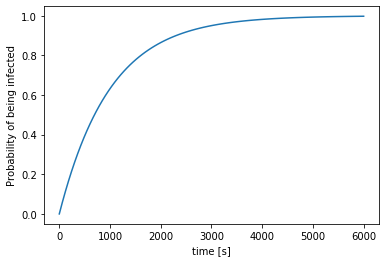

In [69]:
import matplotlib.pyplot as plt
t = np.linspace(0,6000,100)
T = 1000 # Constant for the interaction time which affects the probability of being infected
plt.figure()
plt.plot(t, 1 - np.exp(-t/T))
plt.xlabel('time [s]')
plt.ylabel('Probability of being infected')

We simulate the probability of being infected as an exponential

$$ Probability = 1 - e^{-t/T} $$

where $T$ is a constat that determines how fast the interaction increase the probability of being infected. For example, if a person is in contact with one infected 15 minutes the probability of being infected is almost $P = 60\%$ if $T = 1000 \ s$ and $P = 25\%$ if $T = 3000 \ s$.

In [80]:
T = 1000
probability = 1 - np.exp(-np.array(time_together)/T)
contact_start

[Timedelta('0 days 00:53:59'),
 Timedelta('0 days 11:26:04'),
 Timedelta('0 days 11:49:27'),
 Timedelta('0 days 13:54:01'),
 Timedelta('0 days 13:54:08'),
 Timedelta('0 days 13:54:08'),
 Timedelta('0 days 13:54:20'),
 Timedelta('0 days 13:54:49'),
 Timedelta('0 days 13:58:12'),
 Timedelta('0 days 14:07:03'),
 Timedelta('0 days 11:49:27'),
 Timedelta('0 days 13:54:01'),
 Timedelta('0 days 13:54:08'),
 Timedelta('0 days 13:54:08'),
 Timedelta('0 days 13:54:20'),
 Timedelta('0 days 13:54:49'),
 Timedelta('0 days 13:58:12'),
 Timedelta('0 days 14:07:03'),
 Timedelta('0 days 13:54:08'),
 Timedelta('0 days 13:54:08'),
 Timedelta('0 days 13:54:20'),
 Timedelta('0 days 13:54:49'),
 Timedelta('0 days 13:58:12'),
 Timedelta('0 days 13:54:08'),
 Timedelta('0 days 13:54:20'),
 Timedelta('0 days 13:54:49'),
 Timedelta('0 days 13:58:12'),
 Timedelta('0 days 13:54:20'),
 Timedelta('0 days 13:54:49'),
 Timedelta('0 days 13:54:49'),
 Timedelta('0 days 13:58:12')]

In [83]:
chronology = np.argsort(np.array(contact_start)) # This is the real order of contact between people

In [85]:
import qiskit as qk
from qiskit import IBMQ
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

Credentials are already in use. The existing account in the session will be replaced.


In [107]:
def interaction_circuit(people, interactions, chronology, probability):
    circuit = qk.QuantumCircuit(people,people)
    for case in chronology:
        # with two controlled rotation we simulate the interaction. For instance, if person 1 is infected
        #and is in contact with person 2. The controlled rx rotation will change the probability of person 2
        # based on the contact time between them. The probability is multiplied by pi, because, pi is a rotation
        # from 0 to 1.
        circuit.crx(np.pi*probability[case], interactions[case],interactions[case][::-1])
    return circuit

In [108]:
circuit = interaction_circuit(people,interaction, chronology, probability)

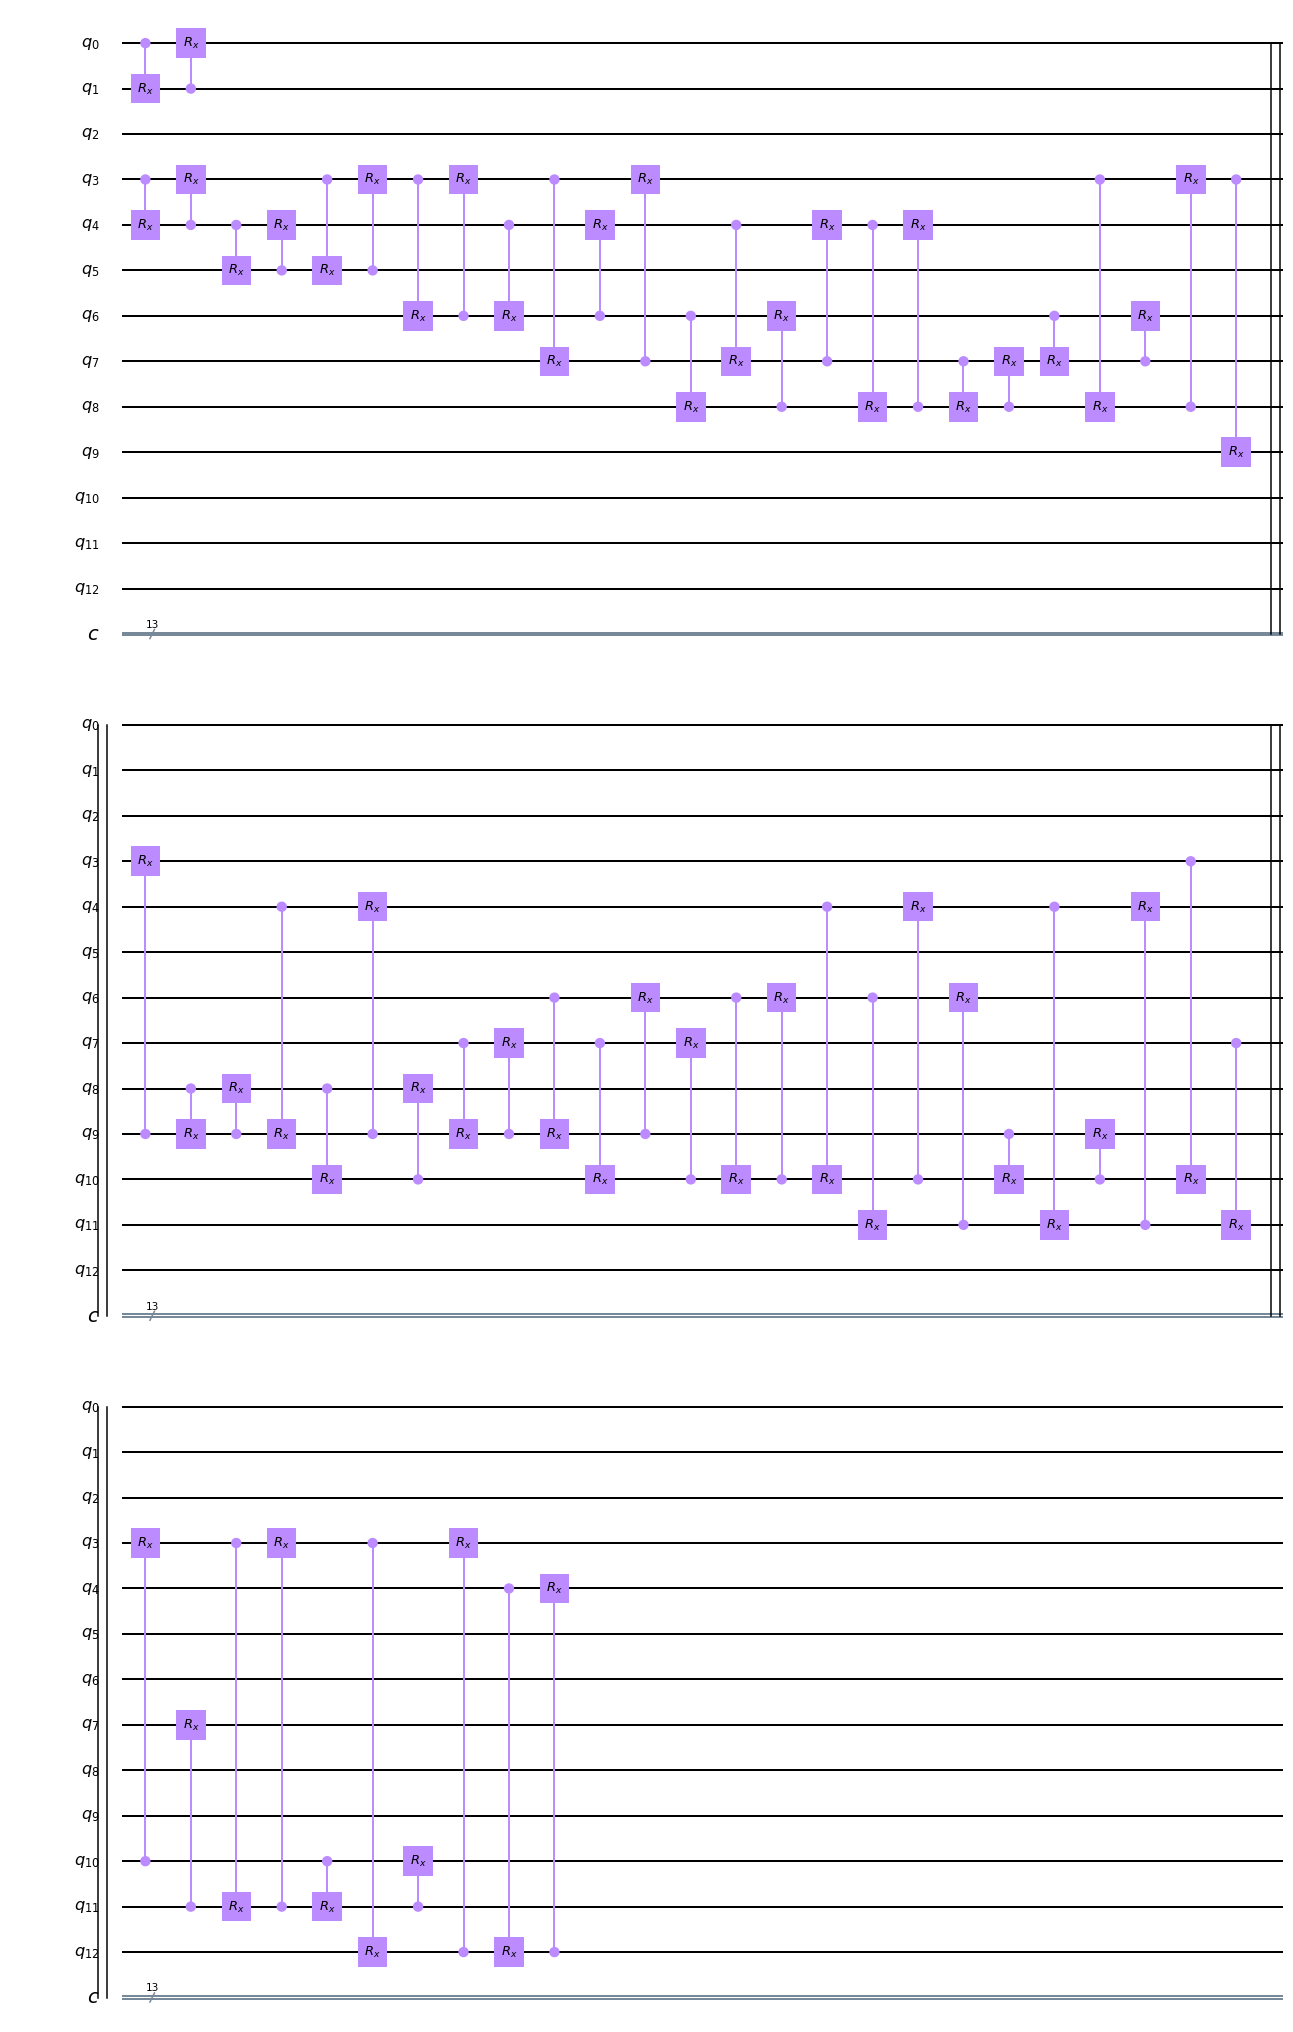

In [109]:
circuit.draw('mpl')

In [110]:
interaction_gate = circuit.to_gate() # This gate compress all the information between interactions

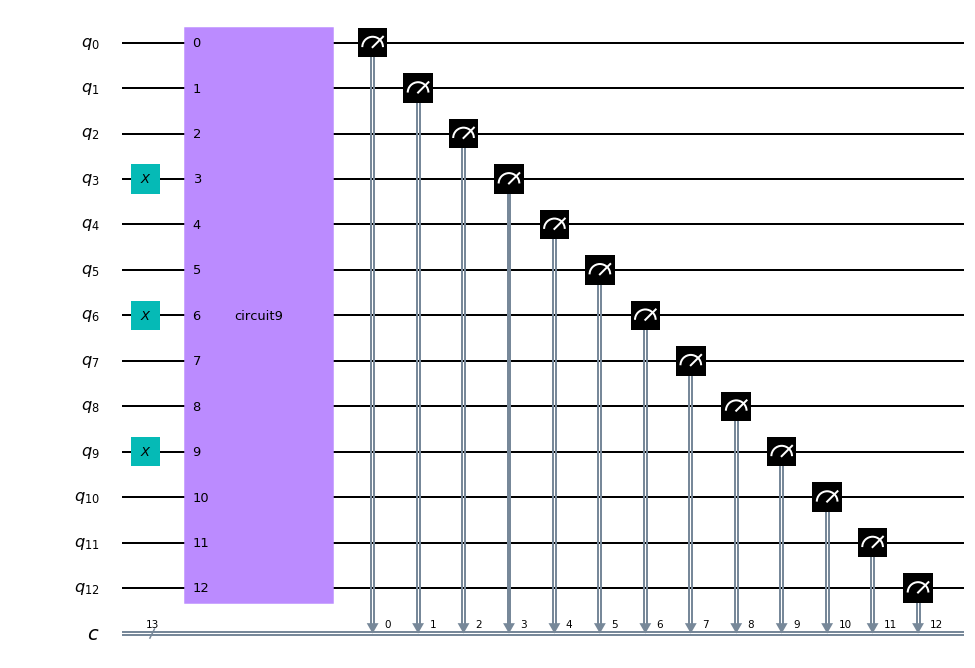

In [111]:
#Now supose three people where testes and give positive, in this case 3,6,9. We only need to add a x gate at the begining to represent such case
circuit_test = qk.QuantumCircuit(people,people)
circuit_test.x([3,6,9])
circuit_test.append(interaction_gate,[i for i in range(people)])
circuit_test.measure([i for i in range(people)],[i for i in range(people)])
circuit_test.draw('mpl')

In [113]:
shots = 1000
job = qk.execute(circuit_test,backend = backend, shots = shots)

In [114]:
def probability_infected(results,qubit,shots):
    #Remember the qubits are counted from right to left, that means q0 position is -1
    one = 0
    for key,count in results.items():
        if key[-(qubit + 1)] == '1':
            one += count
    return 100*(one / shots)

In [115]:
results = job.result().get_counts()

In [116]:
for person in range(people):
    print("Probability P{} of being infected : ".format(person),round(probability_infected(results,person,shots),2))

Probability P0 of being infected :  0.0
Probability P1 of being infected :  0.0
Probability P2 of being infected :  0.0
Probability P3 of being infected :  44.8
Probability P4 of being infected :  31.8
Probability P5 of being infected :  100.0
Probability P6 of being infected :  26.3
Probability P7 of being infected :  49.4
Probability P8 of being infected :  27.1
Probability P9 of being infected :  79.9
Probability P10 of being infected :  61.1
Probability P11 of being infected :  60.3
Probability P12 of being infected :  0.0
